In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
import warnings

In [3]:
PATH = "../data/bulldozers/"

In [4]:
warnings.filterwarnings('ignore')

In [ ]:
df_raw = pd.read_csv(f'{PATH}/train.csv', low_memory=False)

In [ ]:
df_raw.UsageBand

In [5]:
df_raw = pd.read_csv(f'{PATH}/Train.csv', low_memory=False, parse_dates=['saledate'])

In [ ]:
df_raw.saledate

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [ ]:
display_all(df_raw.head().T)

In [7]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

In [ ]:
df_raw.saledate

In [8]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [ ]:
df_raw.head()

In [9]:
train_cats(df_raw)

In [ ]:
df_raw.UsageBand.cat.categories

In [10]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [ ]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

In [11]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [12]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [13]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [ ]:
df.columns

In [ ]:
display_all(df.head())

In [15]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(df, y)
m.score(df,y)

CPU times: user 1min 13s, sys: 123 ms, total: 1min 13s
Wall time: 8.96 s


0.9830564531522613

In [16]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [17]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [18]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 11s, sys: 126 ms, total: 1min 11s
Wall time: 8.64 s
[0.09046125029917888, 0.24606442438914441, 0.9828974842877578, 0.8918701423554928]


In [19]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [20]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.72 s, sys: 2.03 ms, total: 2.73 s
Wall time: 353 ms
[0.11133842647485324, 0.3534743518297632, 0.9729183413492297, 0.7768670087192073]


In [21]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5249387423925456, 0.5813729295177376, 0.3979918729109103, 0.3963883883773268]


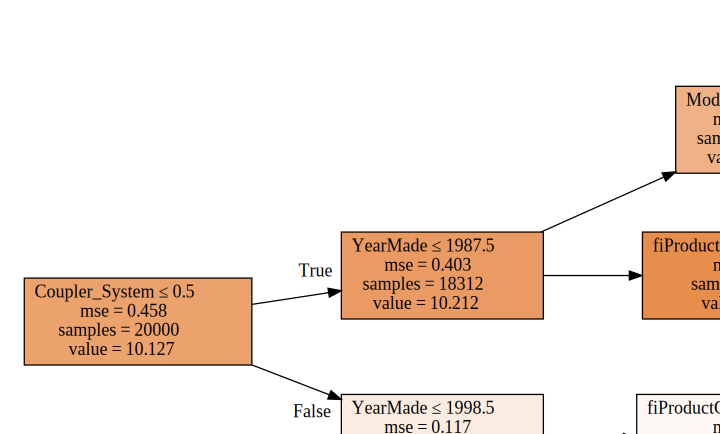

In [22]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [23]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[4.864753555590494e-17, 0.4777656710565097, 1.0, 0.5923590019281899]


In [31]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11317256482669817, 0.35663404615076794, 0.9720187302586947, 0.7728600239432845]


In [25]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.49175, 9.10498, 9.3501 , 9.39266, 9.39266, 9.25913, 9.15905, 9.68034, 9.45329, 8.9872 ]),
 9.327116384582904,
 9.104979856318357)

In [32]:
preds.shape

(10, 12000)

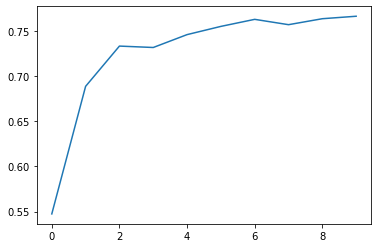

In [42]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [34]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10218481347181708, 0.352802731846792, 0.9771882914455811, 0.777714132158377]


In [41]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09766482113930167, 0.342021867119443, 0.979161741584407, 0.7910916874972215]


In [39]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09337930684064327, 0.346621797651617, 0.9809503766609138, 0.7854345881776941]


In [43]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09778983461989355, 0.34903792743738354, 0.9791083604291964, 0.7824329033220269, 0.8520338723269395]


In [44]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [47]:
set_rf_samples(20000)

In [50]:
reset_rf_samples()

In [48]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7.22 s, sys: 199 ms, total: 7.42 s
Wall time: 2.49 s
[0.24113762251379045, 0.2797292359221718, 0.8784752390462579, 0.8602590497664088, 0.8659102348796297]


In [51]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0784634882496609, 0.23745850605203936, 0.9871332148435212, 0.899301399156414, 0.9083410050604052]


In [53]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1409033999871904, 0.23439577099628486, 0.9585067195384015, 0.9018822642241264, 0.9067161878453959]
